In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-nov-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-nov-2021/train.csv
/kaggle/input/tabular-playground-series-nov-2021/test.csv


In [2]:
# -----------------------------------------------------------------
# Some parameters to config 

EPOCHS = 840
BATCH_SIZE = 2048 
ACTIVATION = 'swish'
LEARNING_RATE = 0.000265713
FOLDS = 5
RANDOM_STATE = 42

# Load Dataset

In [3]:
train_data = pd.read_csv('../input/tabular-playground-series-nov-2021/train.csv',index_col='id')
test_data = pd.read_csv('../input/tabular-playground-series-nov-2021/test.csv',index_col='id')
sample_sub_data = pd.read_csv('../input/tabular-playground-series-nov-2021/sample_submission.csv',index_col='id')

In [4]:
column_y = train_data.columns.difference(test_data.columns)[0]
x = train_data.drop(columns=column_y)
y = train_data[column_y]

x_test = test_data.iloc[:,:]

## Split Dataset

In [5]:
# Check NA
missing_val = x.isnull().sum()
print(missing_val[missing_val > 0])

from sklearn.model_selection import train_test_split 

# x, x_val, y, y_val = train_test_split(x, y, train_size = 0.85, random_state = RANDOM_STATE)

Series([], dtype: int64)


# Scaler transformer

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

transformer_all_cols = make_pipeline(
    StandardScaler(),
    MinMaxScaler(feature_range=(0, 1))
)

preprocessor = make_column_transformer(
    (transformer_all_cols, x.columns[:]),
)

# Model

In [7]:
import keras 
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def load_model(name:str):
    
    early_stopping = EarlyStopping(
        patience=20,
        min_delta=0,
        monitor='val_loss',
        restore_best_weights=True,
        verbose=0,
        mode='min', 
        baseline=None,
    )
    plateau = ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.2, 
            patience=7, 
            verbose=0,
            mode='min')

# -----------------------------------------------------------------
# Model 

    model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(128, activation=ACTIVATION, input_shape = [x.shape[1]]),
    layers.Dropout(rate = 0.5),
    layers.BatchNormalization(),
    layers.Dense(64, activation=ACTIVATION),
    layers.Dropout(rate = 0.5),
    layers.BatchNormalization(),
    layers.Dense(32, activation=ACTIVATION), 
    layers.Dropout(rate = 0.5),
    layers.Dense(1, activation = 'sigmoid'),
    ])

# -----------------------------------------------------------------

    model.compile(
        optimizer= 'adam',
        loss='binary_crossentropy',
        metrics=['AUC'],
    )
    
    return model, early_stopping, plateau

# Kfold

In [8]:
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer

preds_valid_f = {}
preds_test = []
total_auc = []
f_scores = []

kf = StratifiedKFold(n_splits=FOLDS,random_state=RANDOM_STATE,shuffle=True)



In [9]:
for fold,(train_index, valid_index) in enumerate(kf.split(x,y)):

    X_train, X_valid = x.loc[train_index], x.loc[valid_index]
    y_train, y_valid = y.loc[train_index], y.loc[valid_index]

    #   --------------------------------------------------------  
    # Preprocessing
    index_valid  = X_valid.index.tolist()
    test  = test_data.copy()
    
    X_train = preprocessor.fit_transform(X_train)
    X_valid = preprocessor.transform(X_valid)
    test = preprocessor.transform(test)
    
    #  ----------------------------------------------------------    
    # Model
    
    model, early_stopping, plateau  = load_model('version8')

    history = model.fit(  X_train, y_train,
                validation_data = (X_valid, y_valid),
                batch_size = BATCH_SIZE, 
                epochs = EPOCHS,
                callbacks = [early_stopping, plateau],
                shuffle = True,
                verbose = 0
              )

    #  ----------------------------------------------------------
    #  oof
    preds_valid = model.predict(X_valid).reshape(1,-1)[0] 
    
    #  ----------------------------------------------------------
    #  test  predictions
    preds_test.append(model.predict(test).reshape(1,-1)[0])
    
    #  ----------------------------------------------------------
    #  Saving  scores to plot the end  
    scores = pd.DataFrame(history.history)
    scores['folds'] = fold
    
    if fold == 0:
        f_scores = scores 
    else: 
        f_scores = pd.concat([f_scores, scores], axis  = 0)
        
    #  ----------------------------------------------------------
    #  concatenating valid preds
    preds_valid_f.update(dict(zip(index_valid, preds_valid)))

    # Getting score for a fold model
    fold_auc = roc_auc_score(y_valid, preds_valid)
    print(f"Fold {fold} roc_auc_score: {fold_auc}")

    # Total auc
    total_auc.append(fold_auc)

print(f"mean roc_auc_score: {np.mean(total_auc)}, std: {np.std(total_auc)}")


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Fold 0 roc_auc_score: 0.7556225415493394
Fold 1 roc_auc_score: 0.753825537478119
Fold 2 roc_auc_score: 0.7559301524962232
Fold 3 roc_auc_score: 0.7557575813268985
Fold 4 roc_auc_score: 0.7592929085401487
mean roc_auc_score: 0.7560857442781457, std: 0.001774310788757329


# AUC

Validation Loss: 0.5668
Validation Loss: 0.5684
Validation Loss: 0.5651
Validation Loss: 0.5658
Validation Loss: 0.5641


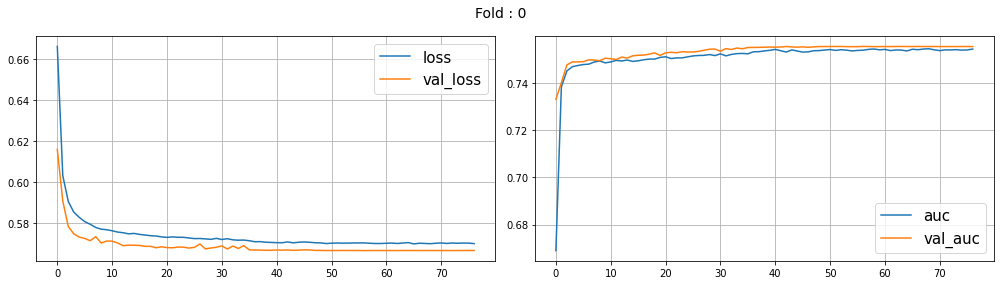

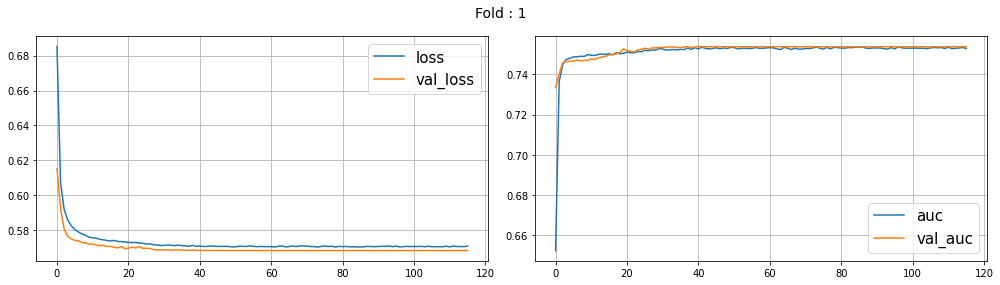

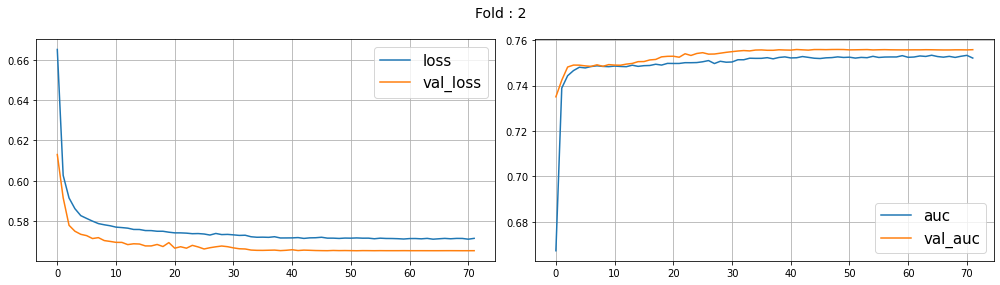

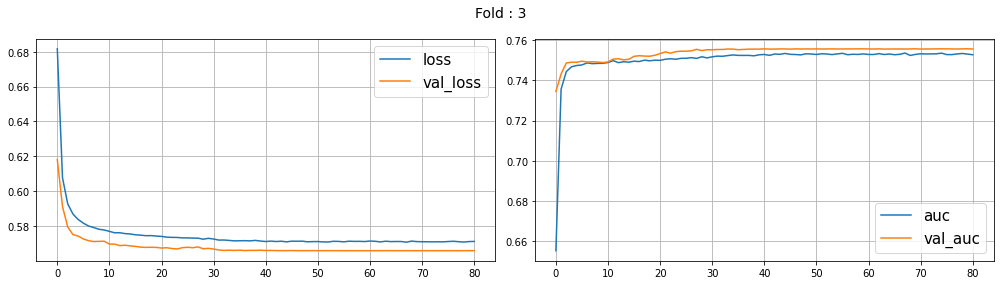

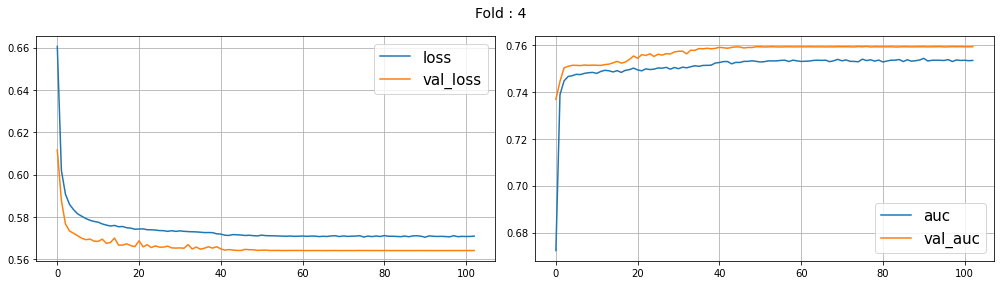

In [10]:
import matplotlib.pyplot as plt

for fold in range(f_scores['folds'].nunique()):
    history_f = f_scores[f_scores['folds'] == fold]

    fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(14,4))
    fig.suptitle('Fold : '+str(fold), fontsize=14)
        
    plt.subplot(1,2,1)
    plt.plot(history_f.loc[:, ['loss', 'val_loss']], label= ['loss', 'val_loss'])
    plt.legend(fontsize=15)
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.plot(history_f.loc[:, ['auc', 'val_auc']],label= ['auc', 'val_auc'])
    plt.legend(fontsize=15)
    plt.grid()
    
    print("Validation Loss: {:0.4f}".format(history_f['val_loss'].min()));

# Submission

In [11]:
sub = pd.read_csv("../input/tabular-playground-series-nov-2021/sample_submission.csv")
sub['target'] = np.mean(preds_test, axis = 0)
sub.to_csv('submission.csv', index=False)
sub.head()

,id,target
0,600000,0.737344
1,600001,0.739233
2,600002,0.744323
3,600003,0.288456
4,600004,0.716306


In [12]:
# sub['target'] = np.mean(preds_test, axis = 0)

In [13]:
# sub